# Lab 8 & 9: Part 2
### Daniel Mehta

## Imports / Loading Data

In [3]:
import os

os.environ["PYSPARK_PYTHON"] = "/opt/anaconda3/envs/moflow/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/anaconda3/envs/moflow/bin/python"

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, try_to_timestamp, col, lit, udf, max,min, lit, sum
from pyspark.sql.types import TimestampType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from dateutil import parser

In [5]:
# start the spark session
spark = SparkSession.builder.appName("RetailRFM").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/31 12:22:27 WARN Utils: Your hostname, Daniels-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.134 instead (on interface en0)
25/07/31 12:22:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/31 12:22:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# load dataset
df = spark.read.csv("OnlineRetail.csv", header=True, inferSchema=True)

In [7]:
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows


## Data Exploration Analysis

In [9]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [10]:
print("Row count:", df.count())

Row count: 541909


In [11]:
print("Column count:", len(df.columns))

Column count: 8


In [12]:
# Counting nulls per column
df.select([
    count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in df.columns
]).show()

+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|InvoiceNo_nulls|StockCode_nulls|Description_nulls|Quantity_nulls|InvoiceDate_nulls|UnitPrice_nulls|CustomerID_nulls|Country_nulls|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|              0|              0|             1454|             0|                0|              0|          135080|            0|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+



In [13]:
# Droping the rows with missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Drop duplicates
df = df.dropDuplicates()

# Updating counts
print("Row count after cleaning:", df.count())
print("Distinct customers:", df.select("CustomerID").distinct().count())

Row count after cleaning: 401604


Distinct customers: 4372


In [14]:
# Summary stats
df.describe(["Quantity","UnitPrice"]).show()

+-------+------------------+-----------------+
|summary|          Quantity|        UnitPrice|
+-------+------------------+-----------------+
|  count|            401604|           401604|
|   mean|12.183272576966365|3.474063639804083|
| stddev|250.28303714445417|69.76403506410995|
|    min|            -80995|              0.0|
|    max|             80995|          38970.0|
+-------+------------------+-----------------+



## RFM Analysis

### Parse Dates and Add "Amount" Column

In [17]:
# parse date
def parse_date_flexible(s):
    try:
        return parser.parse(s)
    except:
        return None

# register the udf
parse_date_udf = udf(parse_date_flexible, TimestampType())

In [18]:
# apply the udf to the invoice date column
df = df.withColumn("InvoiceDate", parse_date_udf(col("InvoiceDate")))

# Drop the ones that couldn’t be parsed
df = df.filter(col("InvoiceDate").isNotNull())

# recalc amount
df = df.withColumn("Amount", col("Quantity") *col("UnitPrice"))

### Calculate Recency (in days)

In [20]:
# Find max date
max_date = df.agg(max("InvoiceDate")).collect()[0][0]

# Creating recency column
df = df.withColumn("Recency",(lit(max_date).cast("long")-col("InvoiceDate").cast("long"))/86400)

# show sample recency
df.select("CustomerID", "InvoiceDate", "Recency").show(5)

+----------+-------------------+------------------+
|CustomerID|        InvoiceDate|           Recency|
+----------+-------------------+------------------+
|     15311|2010-12-01 09:41:00|         373.13125|
|     17511|2010-12-01 10:19:00| 373.1048611111111|
|     17850|2010-12-01 10:51:00| 373.0826388888889|
|     14307|2010-12-01 11:41:00|373.04791666666665|
|     17920|2010-12-01 11:49:00| 373.0423611111111|
+----------+-------------------+------------------+
only showing top 5 rows


### Frequency and Monetary per Customer

In [22]:
# Calc frequency (count of invoices per customer)
freq_df = df.groupBy("CustomerID").agg(count("InvoiceNo").alias("Frequency"))

#Calc monetary (total amount spent per customer)
mon_df = df.groupBy("CustomerID").agg(sum("Amount").alias("Monetary"))

### Combine Recency, Frequency, and Monetary into RFM Table

In [24]:
# takes most recent recency per customer
recency_df = df.select("CustomerID", "Recency").groupBy("CustomerID").agg(min(col("Recency")).alias("Recency"))

# Join all
rfm_df = recency_df.join(freq_df, "CustomerID").join(mon_df, "CustomerID")

# RFM sample
rfm_df.show(5)

+----------+-------------------+---------+------------------+
|CustomerID|            Recency|Frequency|          Monetary|
+----------+-------------------+---------+------------------+
|     17420| 49.956944444444446|       30| 598.8299999999999|
|     16861| 59.197916666666664|        8|            151.65|
|     16503| 106.08611111111111|       86|           1421.43|
|     15727| 16.009722222222223|      301|           5159.06|
|     17389|0.13333333333333333|      224|31300.079999999994|
+----------+-------------------+---------+------------------+
only showing top 5 rows


## Clustering Analysis

In [26]:
# Assembling features into a single vector column
assembler = VectorAssembler(inputCols=["Recency","Frequency","Monetary"],outputCol="features")
rfm_vector =assembler.transform(rfm_df).select("CustomerID","features")

rfm_vector.show(5, truncate=False)

+----------+----------------------------------------------+
|CustomerID|features                                      |
+----------+----------------------------------------------+
|17420     |[49.956944444444446,30.0,598.8299999999999]   |
|16861     |[59.197916666666664,8.0,151.65]               |
|16503     |[106.08611111111111,86.0,1421.43]             |
|15727     |[16.009722222222223,301.0,5159.06]            |
|17389     |[0.13333333333333333,224.0,31300.079999999994]|
+----------+----------------------------------------------+
only showing top 5 rows


In [27]:
# Scale features
scaler = StandardScaler(inputCol="features",outputCol="scaledFeatures",withStd=True, withMean=True)
scaler_model=scaler.fit(rfm_vector)
scaled_data=scaler_model.transform(rfm_vector)

scaled_data.select("CustomerID", "scaledFeatures").show(5,truncate=False)

+----------+---------------------------------------------------------------+
|CustomerID|scaledFeatures                                                 |
+----------+---------------------------------------------------------------+
|17420     |[-0.41311020474246346,-0.2698596378091656,-0.15753124346706404]|
|16861     |[-0.3214118636157202,-0.365835808118127,-0.2119413334472397]   |
|16503     |[0.14386057153394405,-0.02555665884090024,-0.05744237541014624]|
|15727     |[-0.7499691291912288,0.9123922782694043,0.3973292704877114]    |
|17389     |[-0.9075108346725248,0.5764756821880395,3.578006515385898]     |
+----------+---------------------------------------------------------------+
only showing top 5 rows


In [28]:
# use one core
spark = SparkSession.builder \
    .appName("RetailRFM") \
    .master("local[1]") \
    .getOrCreate()

25/07/31 12:29:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


25/07/31 12:31:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


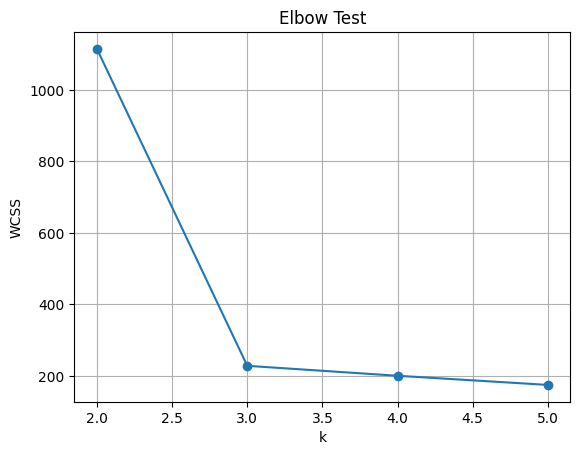

In [29]:
# Plotting elbow
sample_data = scaled_data.sample(withReplacement=False, fraction=0.05, seed=5503).cache()
sample_data.count()

cost = []
for k in range(2, 6):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=5503, maxIter=3)
    model = kmeans.fit(sample_data)
    cost.append(model.summary.trainingCost)

plt.plot(range(2, 6), cost, marker='o')
plt.xlabel("k")
plt.ylabel("WCSS")
plt.title("Elbow Test")
plt.grid(True)
plt.show()

In [30]:
kmeans = KMeans(featuresCol="scaledFeatures", k=3 , seed=5503)
model = kmeans.fit(scaled_data)

# Make predictions
predictions = model.transform(scaled_data)

# Show final cluster assignments
predictions.select("CustomerID", "scaledFeatures", "prediction").show(10, truncate=False)

+----------+---------------------------------------------------------------+----------+
|CustomerID|scaledFeatures                                                 |prediction|
+----------+---------------------------------------------------------------+----------+
|17420     |[-0.41311020474246346,-0.2698596378091656,-0.15753124346706404]|1         |
|16861     |[-0.3214118636157202,-0.365835808118127,-0.2119413334472397]   |1         |
|16503     |[0.14386057153394405,-0.02555665884090024,-0.05744237541014624]|1         |
|15727     |[-0.7499691291912288,0.9123922782694043,0.3973292704877114]    |1         |
|17389     |[-0.9075108346725248,0.5764756821880395,3.578006515385898]     |1         |
|15100     |[2.3639775362285245,-0.37456091450985074,-0.1531181347332634]  |0         |
|12471     |[-0.8901800066922317,1.9114169601217752,2.045578538149169]     |1         |
|16916     |[-0.6803150499765958,0.19257100095219382,-0.16196260327089695] |1         |
|17809     |[-0.7501345128379593

In [31]:
# Counting how many customers in each cluster
predictions.groupBy("prediction").count().orderBy("prediction").show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1099|
|         1| 3259|
|         2|   14|
+----------+-----+

